# Quantium Data Analysis

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline

In [2]:
'''The merged data from task 1 can be used in task 2. However, when I check the data Quantium provided in task 2, the DATE
attritbute is incorrect for task 1. So I used the new data they provided in task 2'''
data = pd.read_csv('QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
#Change data type to save memory
int64 =  data.select_dtypes(include=['int64']).columns.tolist() 
data[int64] = data[int64].astype('int32')

data['TOT_SALES'] = data['TOT_SALES'].astype('float16') #Change float64 to float16

#Change DATE to datetime data
data['DATE'] = pd.to_datetime(data['DATE'],format = '%Y-%m-%d')

#Change STORE_NBR to category data
data['STORE_NBR'] = data['STORE_NBR'].astype('category')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int32         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  category      
 3   TXN_ID            264834 non-null  int32         
 4   PROD_NBR          264834 non-null  int32         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int32         
 7   TOT_SALES         264834 non-null  float16       
 8   PACK_SIZE         264834 non-null  int32         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: category(1), datetime64[ns](1), float16(1), int32(5), object(4)
memory usage: 16.2+ MB


The client has selected store numbers 77, 86 and 88 as trial stores and want 
control stores to be established stores that are operational for the entire 
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present 
throughout the pre-trial period.

In [6]:
#Add a new month ID column in the data with format yyyymm
data['MONTH_ID'] = data['DATE'].dt.to_period('M')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000000,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.699219,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.599609,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000000,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.900391,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


As we only considered stores that have sales every month over July 2018 to June 2019, stores that do not satisfy the condition need to be dropped

In [7]:
count_months = data.groupby('STORE_NBR')['MONTH_ID'].nunique()
count_months = count_months[count_months < 12]
store_to_drop = pd.DataFrame(count_months).index

For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [8]:
data = data.loc[~data.STORE_NBR.isin(store_to_drop)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264645 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264645 non-null  int32         
 1   DATE              264645 non-null  datetime64[ns]
 2   STORE_NBR         264645 non-null  category      
 3   TXN_ID            264645 non-null  int32         
 4   PROD_NBR          264645 non-null  int32         
 5   PROD_NAME         264645 non-null  object        
 6   PROD_QTY          264645 non-null  int32         
 7   TOT_SALES         264645 non-null  float16       
 8   PACK_SIZE         264645 non-null  int32         
 9   BRAND             264645 non-null  object        
 10  LIFESTAGE         264645 non-null  object        
 11  PREMIUM_CUSTOMER  264645 non-null  object        
 12  MONTH_ID          264645 non-null  period[M]     
dtypes: category(1), datetime64[ns](1), float16(1), int32(5), ob

In [9]:
#total sales for each store and month
data['MONTHLY_SALES'] = data.groupby(['STORE_NBR','MONTH_ID'])['TOT_SALES'].transform('sum')

#number of customer for each store and month
data['MONTHLY_CUSTOMER'] = data.groupby(['STORE_NBR','MONTH_ID'])['LYLTY_CARD_NBR'].transform('nunique')

#transactions per customer for each store and month
data['MONTHLY_TRANSACTION'] = data.groupby(['STORE_NBR','MONTH_ID'])['TXN_ID'].transform('count') #Count number of transaction
data['TRANSACTION_PER_CUSTOMER'] = data['MONTHLY_TRANSACTION']/data['MONTHLY_CUSTOMER'] #Number of transaction per customer

#chips per customer for each store and month
data['MONTHLY_QTY'] = data.groupby(['STORE_NBR','MONTH_ID'])['PROD_QTY'].transform('sum') #Total product quantity
data['QTY_PER_CUSTOMER'] = data['MONTHLY_QTY']/data['MONTHLY_CUSTOMER'] #No of chips per customer

#average price per unit
data['AVERAGE_PRICE'] =data['MONTHLY_SALES']/data['MONTHLY_QTY']

In [10]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID,MONTHLY_SALES,MONTHLY_CUSTOMER,MONTHLY_TRANSACTION,TRANSACTION_PER_CUSTOMER,MONTHLY_QTY,QTY_PER_CUSTOMER,AVERAGE_PRICE
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000000,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10,188.125,44,45,1.022727,58,1.318182,3.243534
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.699219,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09,278.750,59,62,1.050847,75,1.271186,3.716667
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.599609,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03,192.875,45,49,1.088889,58,1.288889,3.325431
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000000,175,NATURAL,YOUNG FAMILIES,Budget,2019-03,192.875,45,49,1.088889,58,1.288889,3.325431
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.900391,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11,192.625,46,47,1.021739,57,1.239130,3.379386


Filter to the pretrial period

In [11]:
pre_trial = data[data.MONTH_ID < '2019-02']

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

In [116]:
metric_columns = ['STORE_NBR','MONTH_ID','MONTHLY_SALES','MONTHLY_CUSTOMER','TRANSACTION_PER_CUSTOMER','QTY_PER_CUSTOMER',
                 'AVERAGE_PRICE']
store_num = np.unique(pre_trial['STORE_NBR'])
input_data = pre_trial.loc[:,metric_columns].set_index(['STORE_NBR','MONTH_ID'])
input_data.sort_values(by = ['STORE_NBR','MONTH_ID'],ascending = True, inplace = True)
input_data.drop_duplicates(inplace = True, keep = 'first')

#Function to calculate correlation for a measure, looping through each control store
def cal_corr(input_data, metric_col, store_comparison):
    #Select Store_NBR, Month_ID, and the metric used to calculate correlation on
    metric = input_data[[metric_col]]

    #Loop through each store, calculate correlation
    trial_store = metric.loc[store_comparison]
    series = []
    for i in metric.index:
        corr = trial_store.corrwith(metric.loc[i[0]])
        series.append(corr)
    result = pd.DataFrame(series)
    result.index = metric.index
    result.index = [i[0] for i in result.index] #Select only STORE_NBR as index
    result.index.name = 'STORE_NBR'
    result = result.abs() #Make the correlation ranges from 0 to 1
    result.drop_duplicates(inplace = True)
    result.rename(columns={metric_col:'CORR'},inplace = True)
    return result

In [117]:
#Test if the function work
a = cal_corr(input_data,'MONTHLY_SALES',77)
a.head()

,CORR
STORE_NBR,
77,0.998847
71,0.913691
233,0.903432
119,0.867842
258,0.854345


It works! Now let's create another function to calculate magnitude

In [99]:
def cal_magnitude(input_data, metric_col, store_comparison):  
    #Select Store_NBR, Month_ID, and the metric used to calculate correlation on
    metric = input_data[[metric_col]]
    metric.reset_index(inplace = True)
    #Loop through each store, calculate correlation
    trial_store = metric.loc[metric['STORE_NBR']==store_comparison, metric_col]
    trial_store.reset_index(drop=True, inplace = True)
    series = []
    store_series = []
    
    for i in store_num:
        control_store = metric.loc[metric['STORE_NBR']==i, metric_col]
        control_store.reset_index(drop=True,inplace = True) #Same index with trial_store
        mag = abs(control_store-trial_store) #Subtraction of data records in same index
        mean_mag = np.mean(1-(mag-min(mag))/(max(mag)-min(mag)))
        series.append(mean_mag)
        store_series.append(i)
    result = pd.DataFrame({'STORE_NBR':store_series, 'MAGNITUDE':series})
    return result

In [101]:
b = cal_magnitude(input_data,'MONTHLY_SALES',77)
b.head()

C:\Users\workt\anaconda3\lib\site-packages\pandas\core\nanops.py:146: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


,STORE_NBR,MAGNITUDE
16,18,0.733398
108,115,0.729004
65,69,0.721680
40,43,0.717285
110,118,0.713379


Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

## Trial Store 77

In [118]:
#Calculate correlations against store 77 using total sales and number of customers
trial_store = 77
corr_sales = cal_corr(input_data,'MONTHLY_SALES',trial_store)
corr_customers = cal_corr(input_data,'MONTHLY_CUSTOMER',trial_store)

#Calculate magnitude distance against store 77 using total sales and number of customers
mag_sales = cal_magnitude(input_data,'MONTHLY_SALES',trial_store)
mag_customers = cal_magnitude(input_data,'MONTHLY_CUSTOMER',trial_store)

C:\Users\workt\anaconda3\lib\site-packages\pandas\core\nanops.py:146: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


We'll need to combine all the score calculated using our function to create a composite score to rank on.
Let's take a simpled average of the correlation and magnitude scores for each driver.

In [142]:
#Merge sales score
score_sales = corr_sales.merge(mag_sales, how = 'left', on = 'STORE_NBR')
#Merge no of customer score
score_customers = corr_customers.merge(mag_customers, how = 'left', on = 'STORE_NBR')

In [143]:
#Drop 77
index_drop = score_sales[score_sales['STORE_NBR']==trial_store].index
score_sales.drop(index_drop, inplace = True)
#Calculate control score for sales
score_sales['SCORE_SALES'] = (score_sales['CORR'] + score_sales['MAGNITUDE'])/2
score_sales.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_SALES
1,71,0.913691,0.667480,0.790586
2,233,0.903432,0.489990,0.696711
3,119,0.867842,0.402344,0.635093
4,258,0.854345,0.592773,0.723559
5,17,0.841976,0.409912,0.625944


Now we have a score for each of total number of sales and number of customers. Let's combine the two via a simple average

In [144]:
#Drop store 77
score_customers.drop(index_drop, inplace = True)
#Create control_store column
score_customers['SCORE_CUSTOMERS'] = (score_customers['CORR'] + score_customers['MAGNITUDE'])/2
score_customers.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_CUSTOMERS
1,233,0.990358,0.642857,0.816607
2,119,0.983267,0.476190,0.729729
3,254,0.916208,0.551020,0.733614
4,113,0.901348,0.387755,0.644552
5,84,0.858571,0.571429,0.715000


In [148]:
score_control = score_sales.merge(score_customers, how = 'left', on = 'STORE_NBR')
score_control['FINAL_SCORE'] = (score_control['SCORE_SALES'] + score_control['SCORE_CUSTOMERS'])/2
score_control.sort_values(by = 'FINAL_SCORE',ascending = False, inplace = True)
score_control.head()

,STORE_NBR,CORR_x,MAGNITUDE_x,SCORE_SALES,CORR_y,MAGNITUDE_y,SCORE_CUSTOMERS,FINAL_SCORE
1,233,0.903432,0.489990,0.696711,0.990358,0.642857,0.816607,0.756659
0,71,0.913691,0.667480,0.790586,0.754817,0.571429,0.663123,0.726854
3,258,0.854345,0.592773,0.723559,0.678810,0.640000,0.659405,0.691482
20,84,0.683212,0.629883,0.656548,0.858571,0.571429,0.715000,0.685774
2,119,0.867842,0.402344,0.635093,0.983267,0.476190,0.729729,0.682411


As we can see, store 233 is the store with the highest score, store 233 is then selected as the control score as it is most similar to the trial store.

In [137]:
control_store = 233

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial

In [178]:
#Create a new column store_type
past_sales = pre_trial.loc[:,metric_columns]
past_sales.drop_duplicates(inplace = True)
def store_type(x):
    if x == control_store:
        return 'Control'
    elif x == trial_store:
        return 'Trial'
    else:
        return 'Others'
past_sales['STORE_TYPE'] = past_sales['STORE_NBR'].apply(store_type)

In [179]:
past_sales[past_sales['STORE_TYPE'] == 'Control']

,STORE_NBR,MONTH_ID,MONTHLY_SALES,MONTHLY_CUSTOMER,TRANSACTION_PER_CUSTOMER,QTY_PER_CUSTOMER,AVERAGE_PRICE,STORE_TYPE
231945,233,2018-10,185.750,35,1.028571,1.600000,3.316964,Control
231946,233,2018-12,279.750,47,1.063830,1.595745,3.730000,Control
231947,233,2018-09,228.625,42,1.071429,1.666667,3.266071,Control
231951,233,2018-08,286.000,48,1.041667,1.666667,3.575000,Control
231958,233,2019-01,177.500,35,1.000000,1.342857,3.776596,Control
231988,233,2018-07,290.750,51,1.058824,1.725490,3.303977,Control
231992,233,2018-11,211.625,40,1.025000,1.550000,3.413306,Control


In [184]:
past_sales['MONTH_ID'] = pd.to_datetime(past_sales['MONTH_ID'].astype('str'),format = '%Y-%m')

In [185]:
trial_sales = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_SALES']]
trial_sales.set_index('MONTH_ID',inplace = True)
trial_sales.rename(columns = {'MONTHLY_SALES': 'TRIAL_STORE'}, inplace = True)

control_sales = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_SALES']]
control_sales.set_index('MONTH_ID',inplace = True)
control_sales.rename(columns = {'MONTHLY_SALES': 'CONTROL_STORE'}, inplace = True)

sales_plot = pd.concat([control_sales, trial_sales], axis = 1)
sales_plot

,CONTROL_STORE,TRIAL_STORE
MONTH_ID,,
2018-07-01,290.750,296.750
2018-08-01,286.000,255.500
2018-09-01,228.625,225.250
2018-10-01,185.750,204.500
2018-11-01,211.625,245.250
2018-12-01,279.750,267.250
2019-01-01,177.500,204.375


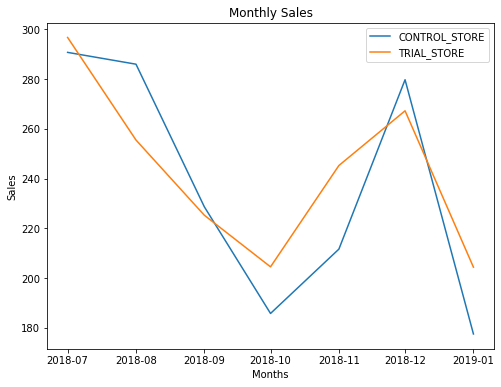

In [199]:
#plot sales of trial and control store
plt.figure(figsize = (8,6))
plt.plot(sales_plot)
plt.title('Monthly Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(sales_plot.columns)
plt.show()

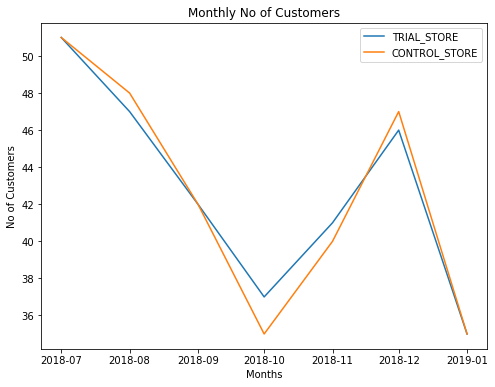

In [200]:
#create customer plot data
trial_customers = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_CUSTOMER']]
trial_customers.set_index('MONTH_ID',inplace = True)
trial_customers.rename(columns = {'MONTHLY_CUSTOMER': 'TRIAL_STORE'}, inplace = True)

control_customers = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_CUSTOMER']]
control_customers.set_index('MONTH_ID',inplace = True)
control_customers.rename(columns = {'MONTHLY_CUSTOMER': 'CONTROL_STORE'}, inplace = True)

customers_plot = pd.concat([trial_customers, control_customers], axis = 1)

#plot number of customers of control and trial store
plt.figure(figsize = (8,6))
plt.plot(customers_plot)
plt.title('Monthly No of Customers')
plt.xlabel('Months')
plt.ylabel('No of Customers')
plt.legend(customers_plot.columns)
plt.show()

In [196]:
customers_plot

,TRIAL_STORE,CONTROL_STORE
MONTH_ID,,
2018-07-01,51,51
2018-08-01,47,48
2018-09-01,42,42
2018-10-01,37,35
2018-11-01,41,40
2018-12-01,46,47
2019-01-01,35,35
